# Deep learning for Bulldozers

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

from fastai.imports import *
from fastai.torch_imports import *
from fastai.dataset import *
from fastai.learner import *
from fastai.structured import *
from fastai.column_data import *

## Load in our data from last lesson

In [47]:
dep = 'SalePrice'
PATH = "data/bulldozers/"
df_raw = pd.read_feather('tmp/raw')
keep_cols = list(np.load('tmp/keep_cols.npy'))

In [48]:
df_raw.loc[df_raw.YearMade<1950, 'YearMade'] = 1950
df_raw['age'] = df_raw.saleYear-df_raw.YearMade
df_raw = df_raw[keep_cols+['age', dep]].copy()
df_indep = df_raw.drop(dep,axis=1)

n_valid = 12000
n_trn = len(df_raw)-n_valid

In [49]:
cat_flds = [n for n in df_indep.columns if df_raw[n].nunique()<n_trn/50]
' '.join(cat_flds)

'YearMade Coupler_System ProductSize fiProductClassDesc ModelID saleElapsed fiSecondaryDesc Enclosure Hydraulics_Flow fiModelDesc fiModelDescriptor Hydraulics Drive_System ProductGroupDesc Tire_Size saleDay state saleWeek ProductGroup Turbocharged age'

In [50]:
cat_flds.remove('saleElapsed')
cat_flds.remove('age')
# cat_flds.remove('YearMade')
[n for n in df_indep.drop(cat_flds,axis=1).columns if not is_numeric_dtype(df_raw[n])]

[]

In [51]:
for n in cat_flds: df_raw[n] = df_raw[n].astype('category').cat.as_ordered()

cont_flds = [n for n in df_indep.columns if n not in cat_flds]
' '.join(cont_flds)

'saleElapsed SalesID MachineID age'

In [52]:
df_raw = df_raw[cat_flds+cont_flds+[dep]]
df, y, mapper = proc_df(df_raw, 'SalePrice', do_scale=True)

val_idx = list(range(n_trn, len(df)))
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, y, cat_flds=cat_flds, bs=64)

In [53]:
df.head()

,YearMade,Coupler_System,ProductSize,fiProductClassDesc,ModelID,fiSecondaryDesc,Enclosure,Hydraulics_Flow,fiModelDesc,fiModelDescriptor,...,Tire_Size,saleDay,state,saleWeek,ProductGroup,Turbocharged,saleElapsed,SalesID,MachineID,age
0,55,0,0,59,644,41,3,0,950,0,...,17,16,1,46,6,0,0.397377,-0.858580,-0.496185,-0.828814
1,47,0,4,62,11,55,3,0,1725,0,...,12,26,33,13,6,0,-0.061496,-0.858578,-2.494936,-0.430749
2,52,1,0,39,1542,0,6,3,331,0,...,0,26,32,9,3,0,-0.075286,-0.858577,-1.775759,-0.762470
3,52,0,6,8,110,0,3,0,3674,0,...,0,19,44,20,4,0,1.179600,-0.858574,-0.434096,-0.298060
4,58,1,0,40,3540,0,1,3,4208,0,...,0,23,32,30,3,0,0.863382,-0.858572,-0.364020,-0.828814


# Embeddings

In [54]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

In [55]:
emb_c = {n: len(c.cat.categories)+1 for n,c in df_raw[cat_flds].items()}
emb_c

{'Coupler_System': 3,
 'Drive_System': 5,
 'Enclosure': 7,
 'Hydraulics': 13,
 'Hydraulics_Flow': 4,
 'ModelID': 5219,
 'ProductGroup': 7,
 'ProductGroupDesc': 7,
 'ProductSize': 7,
 'Tire_Size': 18,
 'Turbocharged': 3,
 'YearMade': 65,
 'fiModelDesc': 5000,
 'fiModelDescriptor': 140,
 'fiProductClassDesc': 75,
 'fiSecondaryDesc': 176,
 'saleDay': 32,
 'saleWeek': 54,
 'state': 54}

In [56]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in emb_c.items()]

In [57]:
m = md.get_learner(emb_szs, len(cont_flds), 0.05, [200,1], [0.05])

In [21]:
m.lr_find()

A Jupyter Widget

 58%|█████▊    | 3555/6081 [00:28<00:14, 171.50it/s, loss=1.52] 

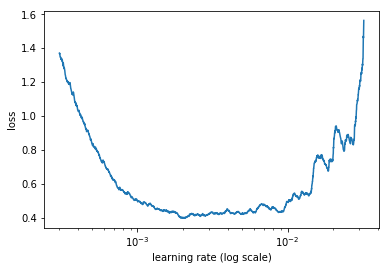

In [29]:
m.sched.plot(1500)

In [ ]:
m.fit(1e-3, 3, 1e-6, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.      0.2315  0.1107]                                       
 67%|██████▋   | 4048/6081 [00:33<00:19, 104.75it/s, loss=0.192]

In [35]:
m.fit(1e-3, 3, 1e-6, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.      0.2425  0.1306]                                       
[ 1.      0.1699  0.1073]                                       
[ 2.      0.1515  0.0836]                                       
[ 3.      0.1468  0.1103]                                       
[ 4.      0.1246  0.1202]                                       
[ 5.      0.1025  0.0729]                                       
[ 6.      0.0964  0.0683]                                        



In [36]:
m.fit(1e-3, 3, 1e-6, cycle_len=4)

A Jupyter Widget

[ 0.      0.1126  0.0746]                                        
[ 1.      0.0977  0.0696]                                        
[ 2.      0.0878  0.0721]                                        
[ 3.      0.0815  0.0628]                                        
[ 4.      0.0921  0.0872]                                        
[ 5.      0.0837  0.0734]                                        
[ 6.      0.0764  0.0625]                                        
[ 7.      0.0733  0.0604]                                        
[ 8.      0.0848  0.0699]                                        
[ 9.      0.0747  0.0587]                                        
[ 10.       0.0671   0.0587]                                     
[ 11.       0.066    0.0578]                                     



In [37]:
m.fit(1e-3, 1, 1e-6, cycle_len=8)

A Jupyter Widget

[ 0.      0.0794  0.0712]                                        
[ 1.      0.0687  0.061 ]                                        
[ 2.      0.0697  0.0632]                                        
[ 3.      0.0591  0.0587]                                        
[ 4.      0.0602  0.0591]                                        
[ 5.      0.0569  0.0579]                                        
[ 6.      0.0558  0.0577]                                        
[ 7.      0.0561  0.0558]                                        



In [39]:
math.sqrt(.056)

0.23664319132398465

In [59]:
0.08**2, 0.211**2

(0.0064, 0.044521)

### Bigger model

In [147]:
class BulldozerModel(nn.Module):
    def __init__(self, n_cat, n_cont):
        super().__init__()
        self.n_cat = n_cat
        self.embs = nn.ModuleList([
            nn.Embedding(c, emb_sz(c)) for _,c in emb_c.items()])
        n_emb = sum(e.embedding_dim for e in self.embs)
        self.l1 = nn.Linear(n_emb+n_cont, 1000)
        self.l2 = nn.Linear(1000, 500)
        self.l3 = nn.Linear(500, 1)
        self.d1 = nn.Dropout(0.05)
        self.d2 = nn.Dropout(0.02)
        self.d3 = nn.Dropout(0.2)
        
    def forward(self, x_cat, x_cont):
        x = [e(x_cat[:,i]) for i,e in enumerate(self.embs)]
        x = self.d1(torch.cat(x, 1))
        x = torch.cat([x, x_cont], 1)
        x = self.d2(F.relu(self.l1(x)))
        x = self.d3(F.relu(self.l2(x)))
        return self.l3(x)

m=BulldozerModel(len(cat_flds), len(cont_flds)).cuda()
opt = optim.Adam(m.parameters(), 1e-3)

In [148]:
fit(m, md, 4, opt, F.mse_loss)

A Jupyter Widget

[ 0.      0.2549  0.4578]                                       
[ 1.      0.1942  0.0954]                                       
[ 2.      0.1656  0.1121]                                       
[ 3.      0.1451  0.1221]                                       



In [149]:
set_lrs(opt,1e-4)

In [150]:
fit(m, md, 1, opt, F.mse_loss)

A Jupyter Widget

[ 0.      0.1198  0.0687]                                       



In [151]:
set_lrs(opt,1e-3)

In [152]:
fit(m, md, 2, opt, F.mse_loss)

A Jupyter Widget

[ 0.      0.1224  0.0751]                                       
[ 1.      0.107   0.1161]                                       



In [153]:
set_lrs(opt,1e-4)

In [154]:
fit(m, md, 3, opt, F.mse_loss)

A Jupyter Widget

[ 0.      0.1007  0.0671]                                        
[ 1.      0.0958  0.068 ]                                        
[ 2.      0.0906  0.0676]                                        

